In [2]:
import tensorflow as tf
import numpy as np
from keras import Model
from keras.layers import Dense, TimeDistributed, Dropout, LayerNormalization, MultiHeadAttention, Layer, Embedding, Add, Input, Concatenate
import keras
from keras.optimizers import Adam

/Users/santiagogonzalez/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:

# Leer el archivo
X = np.load('./data/X_array.npy') #secuencias de 30 notas con acordes, (62188,60,219)
Y = np.load('./data/Y_array.npy') #objetivos: secuencias de notas sin acordes, (62188,60, 195)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [5]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_train.shape,y_train.shape

(TensorShape([49750, 60, 219]), TensorShape([49750, 60, 195]))

In [6]:
#hiperparámetros
n_entrada = 219
n_salida = n_entrada-24
n_heads = 4
#longitud de secuencias
T = 60
#tamaño lote
B = 32
embedding_dim = n_entrada - 79
head_size = embedding_dim//n_heads
dropout_rate = .2
learning_rate = 2e-4
# Definir entradas
inputs = Input(shape=(T, n_entrada))

# Capa densa para llevar los tokens a espacio latente de dimensión embedding_dim
token_emb = TimeDistributed(Dense(embedding_dim))(inputs) #(B,T,embedding_dim)

# Generar los índices de posición
positions = tf.range(start=0, limit=T, delta=1) #(T,)

# Embedding de posición
positional_embedding = Embedding(input_dim=T, output_dim=embedding_dim)
pos_emb = positional_embedding(positions)  # (T, embedding_dim)
# Ajustar pos_emb para que coincida con token_emb
pos_emb = tf.expand_dims(pos_emb, axis=0)  # (1, T, embedding_dim)
tf.tile(pos_emb, [B, 1, 1]) # (batch_size, T, embedding_dim)


# Sumar el embedding de token y el embedding de posición
x = Add()([token_emb, pos_emb])
#Bloque típico de transformer----------------------------------------------------------
x = LayerNormalization()(x)
MHA = MultiHeadAttention(num_heads = n_heads, key_dim = head_size,dropout = dropout_rate, use_bias = False)
#bloque simple de autoatención, use_causal_mask es para que tokens pasados no se comuniquen con futuros
x = MHA(query = x, value = x, use_causal_mask = True) 
x = LayerNormalization()(x)
x_MHA = x
#computación después de comunicación
x = TimeDistributed(Dense(4*embedding_dim))(x)
x = x_MHA+TimeDistributed(Dense(embedding_dim))(x) #skip connection, (B,T,emb_dim)
#---------------------------------------------------------------------------------------
#Bloque típico de transformer----------------------------------------------------------
x = LayerNormalization()(x)
MHA = MultiHeadAttention(num_heads = n_heads, key_dim = head_size,dropout = dropout_rate, use_bias = False)
#bloque simple de autoatención, use_causal_mask es para que tokens pasados no se comuniquen con futuros
x = MHA(query = x, value = x, use_causal_mask = True) 
x = LayerNormalization()(x)
x_MHA = x
#computación después de comunicación
x = TimeDistributed(Dense(4*embedding_dim))(x)
x = x_MHA+TimeDistributed(Dense(embedding_dim))(x) #skip connection
#---------------------------------------------------------------------------------------
#Bloque típico de transformer----------------------------------------------------------
x = LayerNormalization()(x)
MHA = MultiHeadAttention(num_heads = n_heads, key_dim = head_size,dropout = dropout_rate, use_bias = False)
#bloque simple de autoatención, use_causal_mask es para que tokens pasados no se comuniquen con futuros
x = MHA(query = x, value = x, use_causal_mask = True) 
x = LayerNormalization()(x)
x_MHA = x
#computación después de comunicación
x = TimeDistributed(Dense(4*embedding_dim))(x)
x = x_MHA+TimeDistributed(Dense(embedding_dim))(x) #skip connection
#---------------------------------------------------------------------------------------
#regularización final
x = LayerNormalization()(x)
x = TimeDistributed(Dense(n_salida))(x)#(B,T,197)
pitch_logits = x[:,:,0:128] #(B,T,128)
duration_logits = x[:,:,128:142] #(B,T,14)
offset_logits = x[:,:,142:195]#(B,T,53)
pitch_softmax_layer = TimeDistributed(Dense(128, activation='softmax', use_bias=False))
duration_softmax_layer = TimeDistributed(Dense(14, activation='softmax', use_bias=False))
offset_softmax_layer = TimeDistributed(Dense(53, activation='softmax', use_bias=False))

# Aplicar las capas Dense para obtener las salidas softmax
pitch_softmax = pitch_softmax_layer(pitch_logits)
duration_softmax = duration_softmax_layer(duration_logits)
offset_softmax = offset_softmax_layer(offset_logits)

# Congelar los pesos de las capas Dense y establecer los pesos como la matriz identidad
@tf.keras.utils.register_keras_serializable()
def set_identity_weights(layer):
    dense_layer = layer.layer
    dense_layer.set_weights([tf.eye(dense_layer.units)])
set_identity_weights(pitch_softmax_layer)
set_identity_weights(duration_softmax_layer)
set_identity_weights(offset_softmax_layer)


def custom_loss(y_true, y_pred):
    # Segmentar las predicciones
    pitch_pred = y_pred[:, :, :128]
    duration_pred = y_pred[:, :, 128:142]
    offset_pred = y_pred[:, :, 142:]

    # Segmentar las etiquetas verdaderas
    y_pitch = y_true[:, :, :128]
    y_duration = y_true[:, :, 128:142]
    y_offset = y_true[:, :, 142:]

    # Calcular la pérdida categorical crossentropy por cada segmento
    loss_pitch = tf.keras.losses.categorical_crossentropy(y_pitch, pitch_pred)
    loss_duration = tf.keras.losses.categorical_crossentropy(y_duration, duration_pred)
    loss_offset = tf.keras.losses.categorical_crossentropy(y_offset, offset_pred)
    loss_pitch = tf.reduce_mean(loss_pitch, axis = 0)
    loss_duration = tf.reduce_mean(loss_duration, axis = 0)
    loss_offset = tf.reduce_mean(loss_offset, axis = 0)

    # Combinar las pérdidas (promediar o sumar)
    total_loss = (128*loss_pitch + 14*loss_duration + 53*loss_offset)/195  # Sumar las pérdidas
    return total_loss

# Capa de salida 
outputs = Concatenate(axis=-1)([pitch_softmax, duration_softmax, offset_softmax])

# Definir el modelo
model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate = learning_rate)
# Compilar el modelo
model.compile(optimizer=optimizer, loss=custom_loss)

# Mostrar resumen del modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 219)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 60, 140)   │     30,800 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 60, 140)      │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (1, 60, 140)      │        280 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (1, 60, 560)      │     78,960 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (1, 60, 140)      │     78,540 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 60, 140)      │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (1, 60, 560)      │     78,960 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (1, 60, 140)      │     78,540 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 60, 140)      │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 787,344 (3.00 MB)

 Trainable params: 787,344 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.load_weights('modeloCORTO.weights.h5')
history = model.fit(X_train, y_train, epochs=10, batch_size=B, validation_data=(X_val, y_val))

Epoch 1/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 408s 262ms/step - loss: 1.7667 - val_loss: 1.5943
Epoch 2/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 408s 263ms/step - loss: 1.7632 - val_loss: 1.5944
Epoch 3/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 408s 263ms/step - loss: 1.7614 - val_loss: 1.5846
Epoch 4/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 411s 264ms/step - loss: 1.7615 - val_loss: 1.5824
Epoch 5/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 417s 268ms/step - loss: 1.7560 - val_loss: 1.5809
Epoch 6/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 417s 268ms/step - loss: 1.7568 - val_loss: 1.5789
Epoch 7/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 412s 265ms/step - loss: 1.7515 - val_loss: 1.5746
Epoch 8/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 412s 265ms/step - loss: 1.7504 - val_loss: 1.5681
Epoch 9/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 415s 267ms/step - loss: 1.7500 - val_loss: 1.5679
Epoch 10/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 411s 264ms/step - loss: 1.7444 - val_loss: 1.5590


In [16]:
model.save_weights('modeloCORTO.weights.h5')

In [17]:
model.save('modeloCORTO.keras',include_optimizer=False)

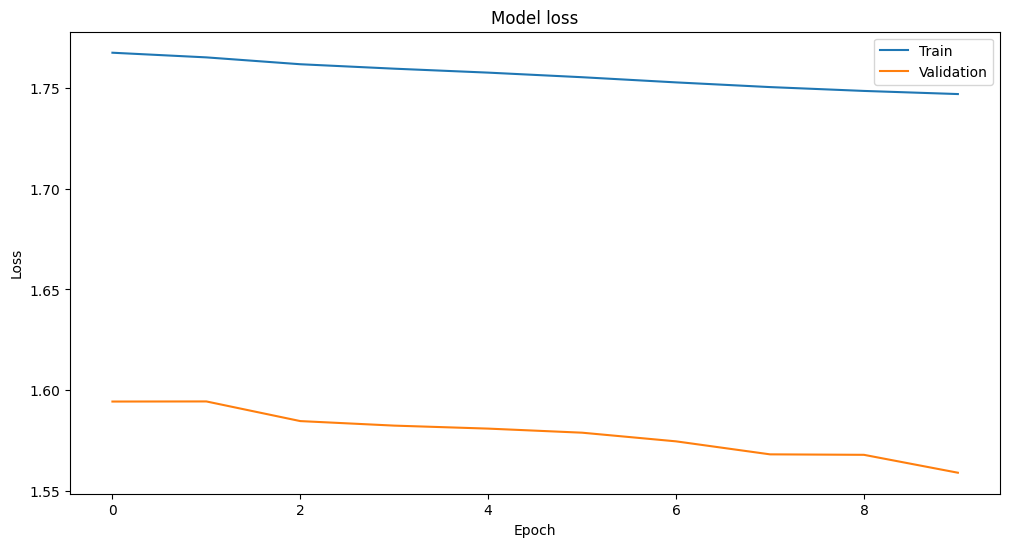

In [15]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [18]:
#cargar modelo sin optimizador
loaded_model = tf.keras.models.load_model('modeloCORTO.keras', custom_objects={'custom_loss': custom_loss})
optimizer = Adam(learning_rate = learning_rate)
loaded_model.compile(optimizer=optimizer, loss=custom_loss)
loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 219)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 60, 140)   │     30,800 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 60, 140)      │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (1, 60, 140)      │        280 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (1, 60, 560)      │     78,960 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (1, 60, 140)      │     78,540 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 60, 140)      │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (1, 60, 560)      │     78,960 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (1, 60, 140)      │     78,540 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 60, 140)      │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 787,344 (3.00 MB)

 Trainable params: 787,344 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

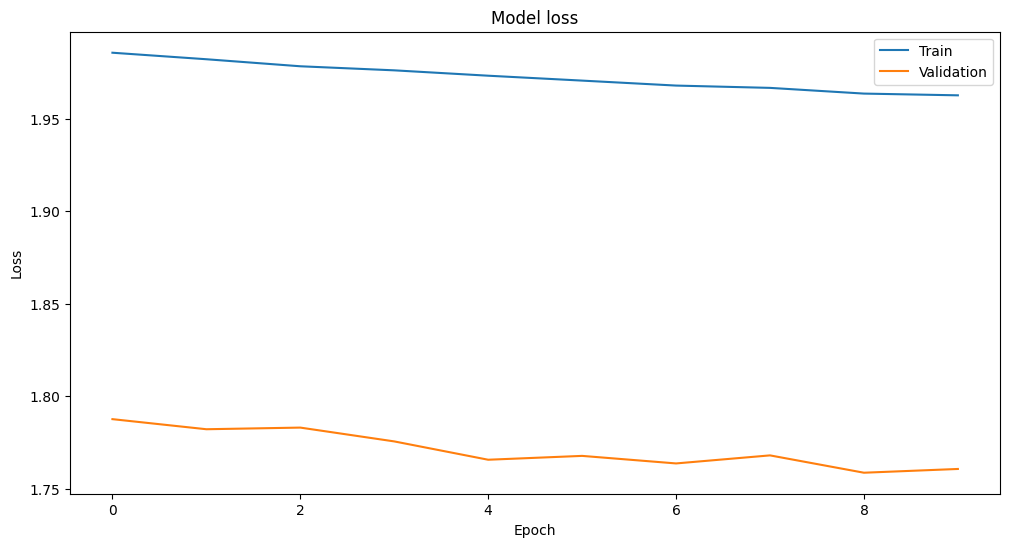

In [37]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()